In [4]:
import sys
sys.path.append('../Utils')
import Solve_Slice
from Solve_Slice import find_B, scatter_pies, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music, select_informative_genes
from CreateRef import createscRef_py
import anndata as ad
import numpy as np
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
adata = ad.read_h5ad("../Data/sc_data.h5ad")

B = find_B_music(adata)
B.to_numpy().shape

pd_B = B.T

genes_subset = select_informative_genes(pd_B)
print(len(genes_subset) )
print(pd_B.shape)
pd_B = pd_B.loc[:,genes_subset]

15678
(20, 19736)


In [6]:
B

,Acinar_cells,Ductal_terminal_ductal_like,Ductal_CRISP3_high-centroacinar_like,Cancer_clone_A,Ductal_MHC_Class_II,Cancer_clone_B,mDCs_A,Ductal_APOL1_high-hypoxic,Tuft_cells,mDCs_B,pDCs,Endocrine_cells,Endothelial_cells,Macrophages_A,Mast_cells,Macrophages_B,T_cells_&_NK_cells,Monocytes,RBCs,Fibroblasts
A1BG,0.076923,0.000000,0.001890,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.090909,0.153846,0.666667,0.000000,0.000000,0.142857,0.000000,0.050,0.000000,0.000000,0.2
A1CF,0.000000,0.077143,0.160681,0.007937,0.153310,0.000000,0.000000,0.093023,0.00000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
A2M,0.000000,0.000000,0.001890,0.000000,0.000000,0.000000,1.750000,0.004651,0.03125,2.090909,0.000000,0.000000,7.000000,0.714286,0.000000,0.052632,0.000,0.000000,0.000000,0.8
A2ML1,0.000000,0.008571,0.001890,0.007937,0.000000,0.752941,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.000000,0.000000,0.000000,0.007937,0.000000,0.005882,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0
ZYG11B,0.000000,0.271429,0.274102,0.214286,0.250871,0.205882,0.166667,0.232558,0.09375,0.212121,0.000000,0.333333,0.181818,0.285714,0.142857,0.105263,0.075,0.111111,0.000000,0.2
ZYX,0.000000,0.945714,0.807183,0.769841,0.637631,0.752941,2.166667,0.944186,0.37500,1.242424,0.538462,0.000000,1.545455,1.333333,0.571429,1.526316,0.950,1.444444,0.066667,0.8
ZZEF1,0.076923,0.111429,0.090737,0.071429,0.111498,0.052941,0.083333,0.060465,0.00000,0.060606,0.230769,0.333333,0.272727,0.000000,0.071429,0.052632,0.100,0.000000,0.000000,0.0


In [8]:
adata = ad.read_h5ad("../Data/spatial.h5ad")
import scanpy as sc
import scipy.sparse as sp
n_top = 20000
# --- 1) Remove non-finite values in X (works for dense or sparse) ---
if sp.issparse(adata.X):
    d = adata.X.data
    bad = ~np.isfinite(d)
    if bad.any():
        d[bad] = 0.0
else:
    adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)

# (Optional) also sanitize any layers to be safe
for lyr in getattr(adata, "layers", {}) or {}:
    Xl = adata.layers[lyr]
    if sp.issparse(Xl):
        dl = Xl.data
        badl = ~np.isfinite(dl)
        if badl.any():
            dl[badl] = 0.0
    else:
        adata.layers[lyr] = np.nan_to_num(Xl, nan=0.0, posinf=0.0, neginf=0.0)

# --- 2) Basic preproc (HVG expects normalized/log data) ---
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top)

mask = adata.var['highly_variable']
gene_names = adata.var_names[mask]
print(gene_names)

Index(['X5_8S_rRNA', 'X7SK', 'A1BG.AS1', 'A1CF', 'A2M', 'A2M.AS1', 'A4GALT',
       'A4GNT', 'AAAS', 'AACS',
       ...
       'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'snoU109', 'snoU2.30'],
      dtype='object', length=20000)


In [9]:
# adata = ad.read_h5ad("../Data/spatial.h5ad")
# adata = adata[~adata.obs.isna().any(axis=1)].copy()
V = solve_V_per_slice(adata, pd_B, lam=0.1)

Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.420282e+06  rel_drop=1.168e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=8.822119e+06  rel_drop=4.381e-05  step=1.56e-05
iter   73  f=8.817541e+06  rel_drop=9.466e-06  step=1.56e-05
stopped after iteration # 73
stopped after iteration #73


In [10]:
all_types = pd_B.index.to_list()
all_types

['Acinar_cells',
 'Ductal_terminal_ductal_like',
 'Ductal_CRISP3_high-centroacinar_like',
 'Cancer_clone_A',
 'Ductal_MHC_Class_II',
 'Cancer_clone_B',
 'mDCs_A',
 'Ductal_APOL1_high-hypoxic',
 'Tuft_cells',
 'mDCs_B',
 'pDCs',
 'Endocrine_cells',
 'Endothelial_cells',
 'Macrophages_A',
 'Mast_cells',
 'Macrophages_B',
 'T_cells_&_NK_cells',
 'Monocytes',
 'RBCs',
 'Fibroblasts']

In [46]:
# adata = ad.read_h5ad("../Data/spatial.h5ad")   # replace with your filename
# print(adata)

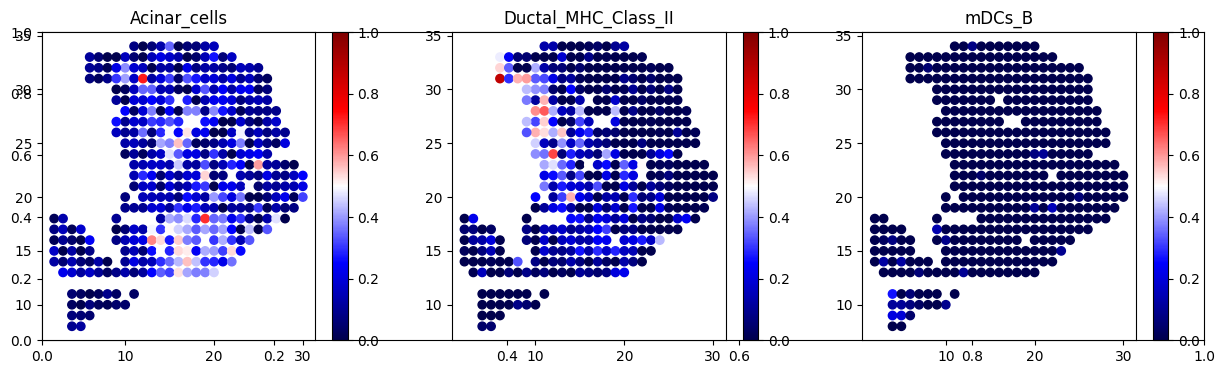

In [11]:
cell_idx = [0,4,9]
import matplotlib.pyplot as plt
plt.subplots(figsize=(15, 4))
for k in range(3):
    plt.subplot(1,3,k+1)

    plt.scatter(adata.obs['x'],adata.obs['y'],c=V[:,cell_idx[k]],cmap='seismic')
    plt.colorbar()
    plt.clim([0,1])
    plt.title(all_types[cell_idx[k]])
plt.show()

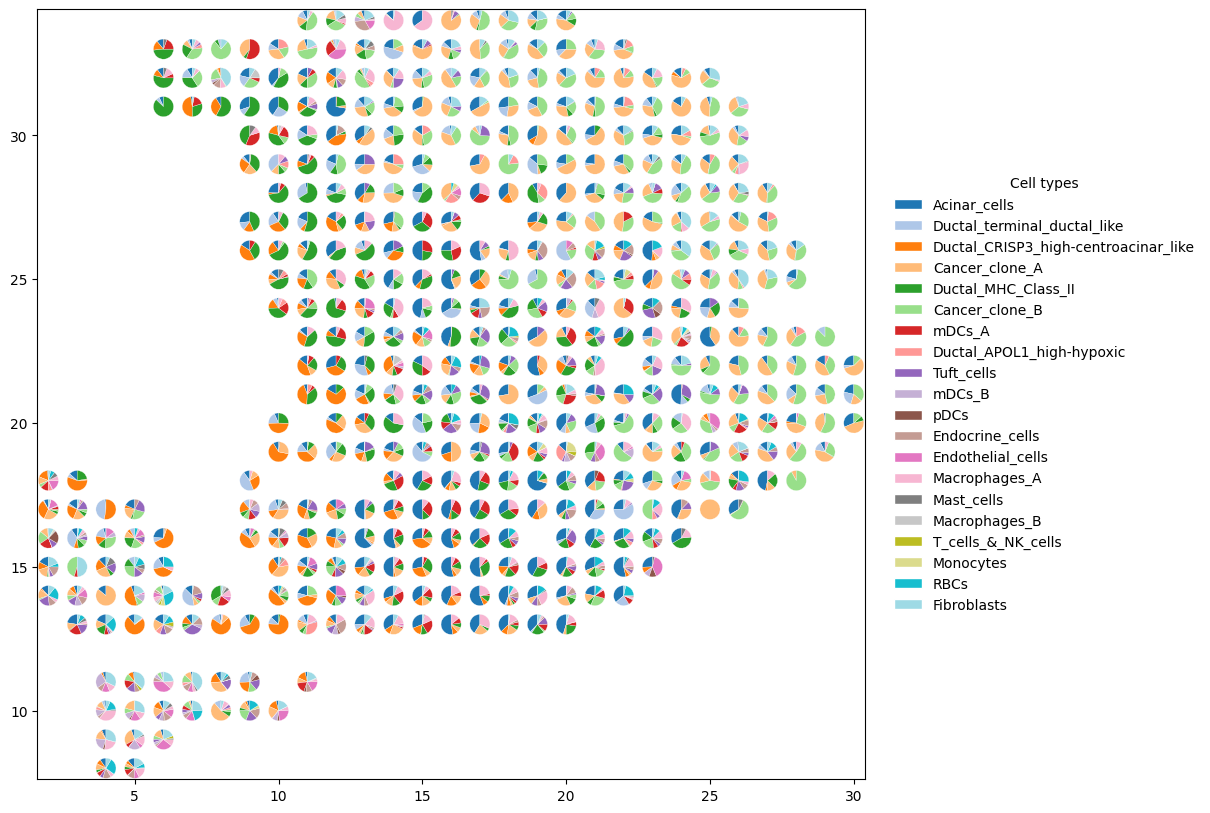

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))

scatter_pies(ax, adata.obs['x'], adata.obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
plt.show()

# Now try imputation using Gaussian process

In [38]:
subsample = list(range(0, adata.obs['x'].shape[0], 4))
complement = np.setdiff1d(np.arange(adata.obs['x'].shape[0]), subsample)
all_coords = np.vstack( (adata.obs['x'], adata.obs['y'] ) )
train_coords = all_coords[:, complement ].T
Vtrain = V[complement,:]
test_coords = all_coords[:, subsample].T

from Impute import gp_impute_spots

Vtest, _ = gp_impute_spots(
    train_coords, Vtrain, test_coords,
    kernel_type="RBF",
    length_scale=3.0,
    noise_level=1e-2,
    optimize_hyperparams=False,
    clip_to_01=True,
    renormalize_rows=True,
    return_std=True
)

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_proc

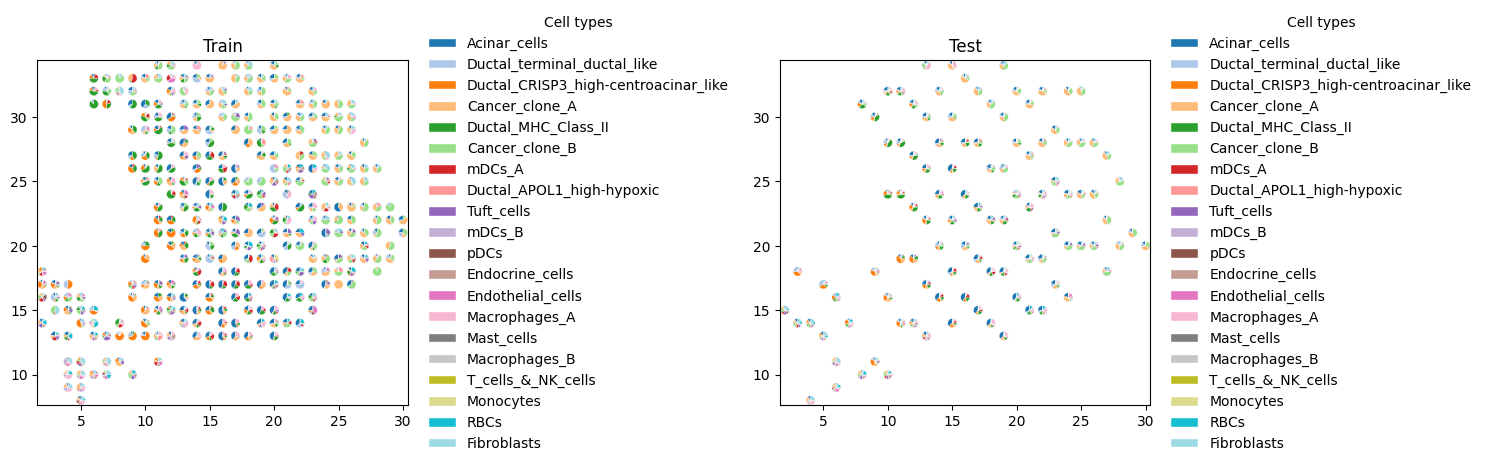

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns
scatter_pies(axs[0], train_coords[:,0], train_coords[:,1], Vtrain,
             labels=pd_B.index.to_list(), top_n=None)
axs[0].set_title("Train")

scatter_pies(axs[1], test_coords[:,0], test_coords[:,1], Vtest,
             labels=pd_B.index.to_list(), top_n=None)
axs[1].set_title("Test")

plt.tight_layout()
plt.show()


# Below try imputation with temporal

In [41]:
def perturb_and_subsample(
    adata, frac=0.5, noise_std=None, dropout_p=None, seed=None
):
    
    rng = np.random.default_rng(seed)

    # --- Subsample rows (cells) ---
    n_obs = adata.n_obs
    n_keep = int(np.ceil(frac * n_obs))
    keep_idx = rng.choice(n_obs, n_keep, replace=False)
    adata_sub = adata[keep_idx].copy()

    # --- Perturb X if requested ---
    X = adata_sub.X
    if hasattr(X, "toarray"):  # convert sparse if needed
        X = X.toarray()

    if noise_std is not None:
        X = X + rng.normal(0, noise_std, size=X.shape)

    if dropout_p is not None:
        mask = rng.random(X.shape) < dropout_p
        X = X.copy()
        X[mask] = 0

    adata_sub.X = X
    adata_sub.uns["perturbation"] = dict(
        noise_std=noise_std, dropout_p=dropout_p, frac=frac
    )
    return adata_sub

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/_utils/__init__.py:555: RuntimeWarning: overflow encountered in multiply
  return x * y
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: overflow encountered in square
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: invalid value encountered in subtract
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/l

Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(214, 1377)
(1377, 20)
iter    0  f=5.053537e+06  rel_drop=3.471e-02  step=7.81e-06
iter   50  f=4.835620e+06  rel_drop=3.825e-05  step=7.81e-06
iter   51  f=4.835597e+06  rel_drop=4.775e-06  step=3.13e-05
stopped after iteration # 51
stopped after iteration #51
(214, 1377)
(1377, 20)
iter    0  f=5.218788e+06  rel_drop=3.097e-02  step=7.81e-06


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:462: RuntimeWarning: divide by zero encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:462: RuntimeWarning: overflow encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:462: RuntimeWarning: invalid value encountered in matmul
  G = X.T @ B
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V

iter   41  f=4.990887e+06  rel_drop=3.369e-06  step=1.56e-05
stopped after iteration # 41
stopped after iteration #41
(428, 1377)
(1377, 20)
iter    0  f=1.026914e+07  rel_drop=3.232e-02  step=7.81e-06
iter    9  f=9.940839e+06  rel_drop=8.125e-06  step=1.56e-05
stopped after iteration # 9
stopped after iteration #9
iter    0  f=9.940839e+06  rel_drop=-1.162e-02


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:592: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:592: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:592: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:594: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:594: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:594: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-package

(428, 1377)
(1377, 20)
iter    0  f=1.026914e+07  rel_drop=3.232e-02  step=7.81e-06
iter    9  f=9.940839e+06  rel_drop=8.130e-06  step=1.56e-05
stopped after iteration # 9
stopped after iteration #9
iter    1  f=9.940839e+06  rel_drop=3.057e-08
stopped after iteration # 1


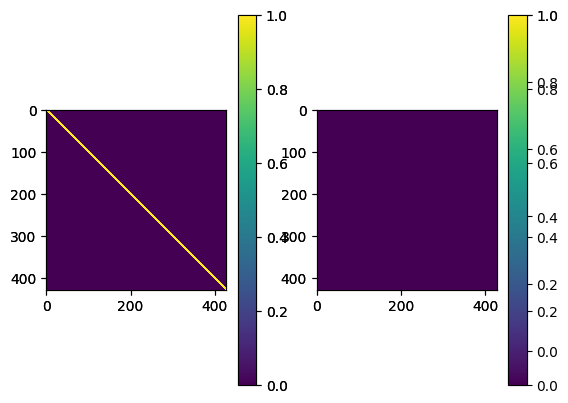

In [42]:

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]
# adata_group = [adata, adata]
V_all, pi, L = solve_V_all_slices(adata_group, pd_B, mu=.5, lam=50)

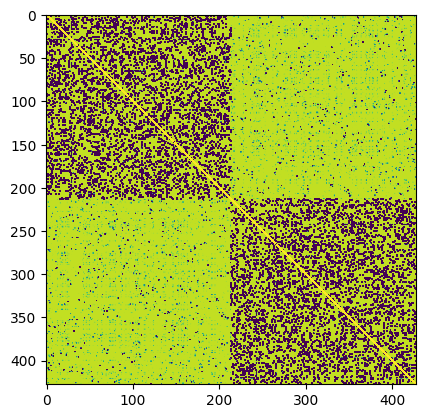

In [44]:
plt.imshow(L.todense())
plt.clim([-0.001,0.0001])

single slice each time
Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.420282e+06  rel_drop=1.168e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=8.822119e+06  rel_drop=4.381e-05  step=1.56e-05
iter   73  f=8.817541e+06  rel_drop=9.466e-06  step=1.56e-05
stopped after iteration # 73
stopped after iteration #73
Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.420282e+06  rel_drop=1.168e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:477: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:479: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=8.822119e+06  rel_drop=4.381e-05  step=1.56e-05
iter   73  f=8.817541e+06  rel_drop=9.466e-06  step=1.56e-05
stopped after iteration # 73
stopped after iteration #73


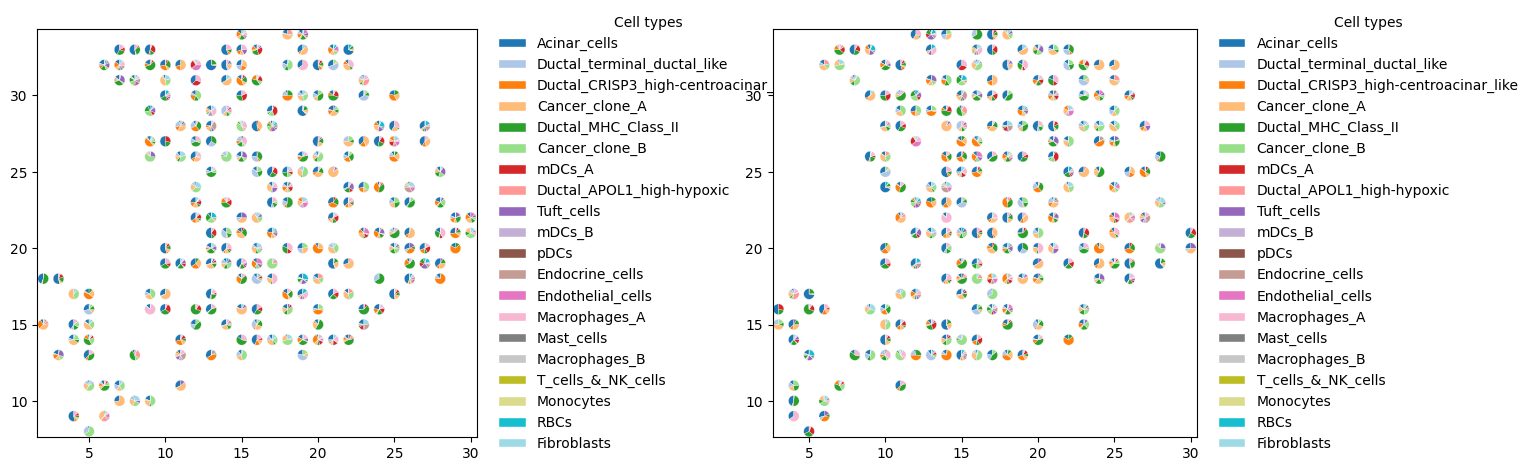

two slices jointly


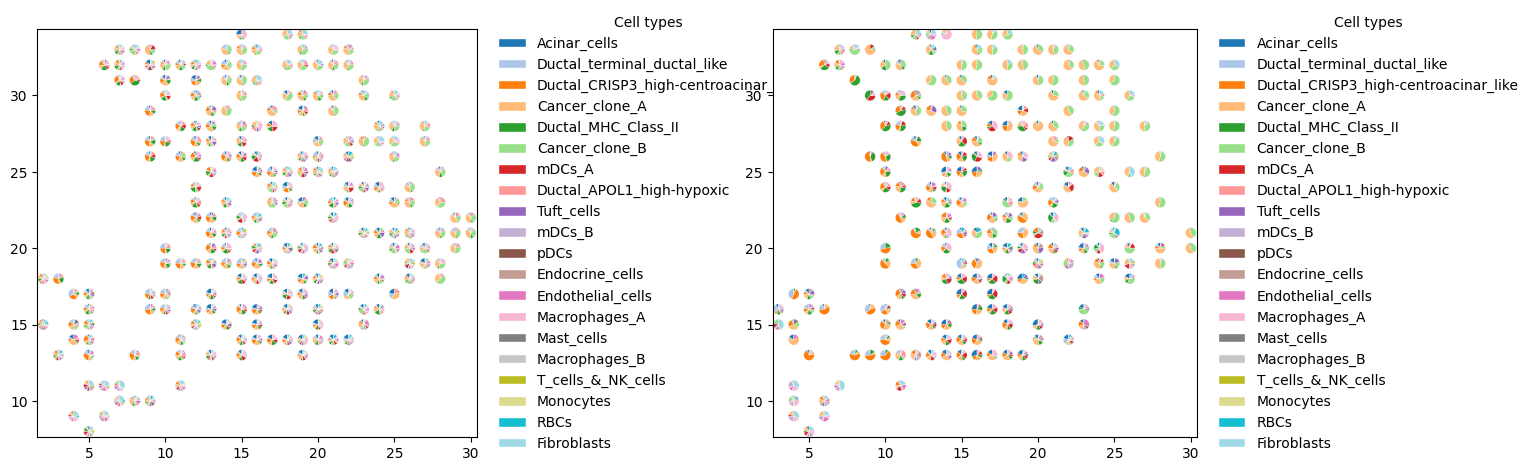

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

print('single slice each time')

V = solve_V_per_slice(adata, pd_B, lam=0.1)
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
V = solve_V_per_slice(adata, pd_B, lam=0.1)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
plt.tight_layout()
plt.show()

print('two slices jointly')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)
plt.tight_layout()
plt.show()

In [68]:
subsample = list(range(0, adata_group[1].obs['x'].shape[0], 4))
complement = np.setdiff1d(np.arange(adata_group[1].obs['x'].shape[0]), subsample)
all_coords = np.vstack( (adata_group[1].obs['x'], adata_group[1].obs['y'] ) )
train_coords = all_coords[:, complement ].T
Vtrain = V_all[1][complement,:]
test_coords = all_coords[:, subsample].T

from Impute import gp_impute_spots_cross_slice

Vtest, _ = gp_impute_spots_cross_slice(
    train_coords, Vtrain, test_coords,
    kernel_type="RBF",
    length_scale=3.0,
    noise_level=1e-2,
    optimize_hyperparams=False,
    clip_to_01=True,
    renormalize_rows=True,
    return_std=True
)

Vtest_temporal, _ = gp_impute_spots_cross_slice(
    train_coords, Vtrain, test_coords,
    kernel_type="RBF",
    length_scale=3.0,
    noise_level=1e-2,
    optimize_hyperparams=False,
    clip_to_01=True,
    renormalize_rows=True,
    return_std=True,
    W_test_prev = pi[0][:,subsample].T,
    V_prev = V_all[0],
    w_within = 0.0, w_prev = 1.0
)

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/sklearn/gaussian_proc

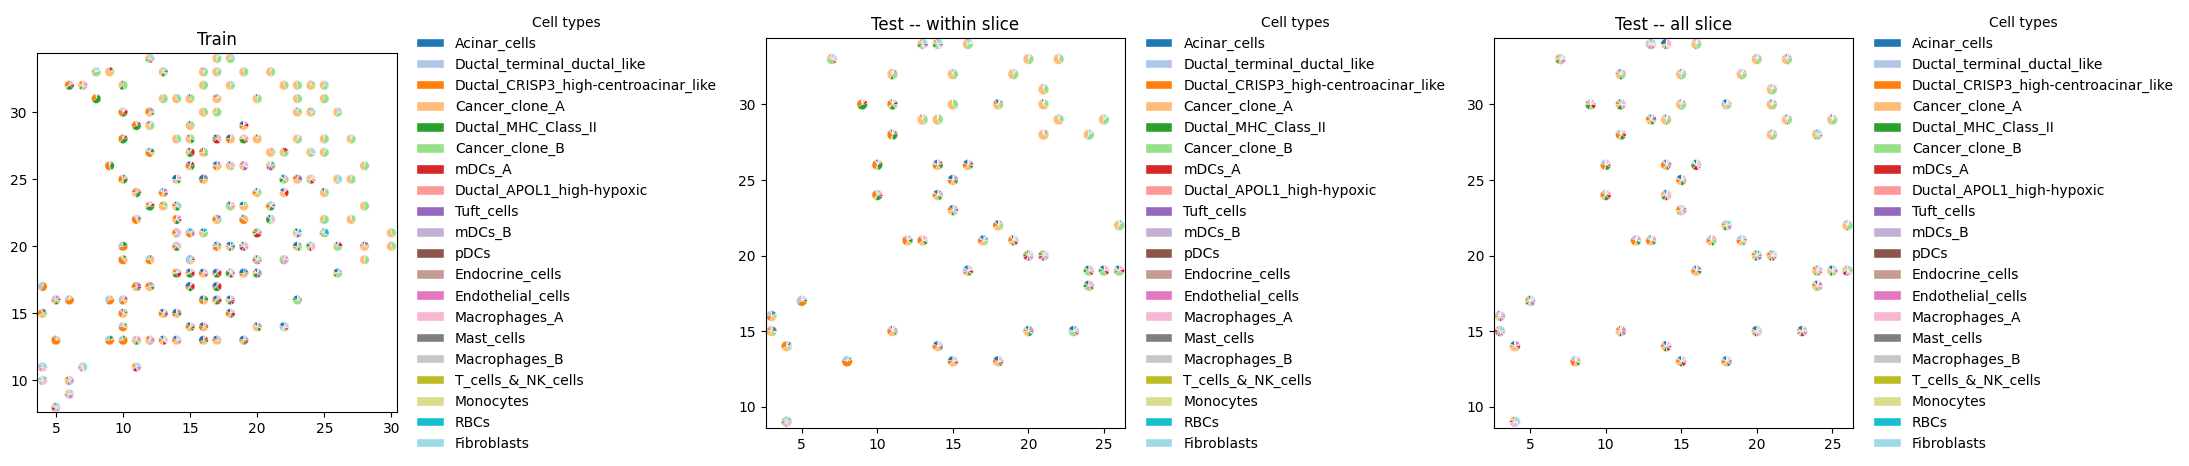

In [69]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(22, 7))  # 1 row, 2 columns
scatter_pies(axs[0], train_coords[:,0], train_coords[:,1], Vtrain,
             labels=pd_B.index.to_list(), top_n=None)
axs[0].set_title("Train")

scatter_pies(axs[1], test_coords[:,0], test_coords[:,1], Vtest,
             labels=pd_B.index.to_list(), top_n=None)
axs[1].set_title("Test -- within slice")

scatter_pies(axs[2], test_coords[:,0], test_coords[:,1], Vtest_temporal,
             labels=pd_B.index.to_list(), top_n=None)
axs[2].set_title("Test -- all slice")

plt.tight_layout()
plt.show()

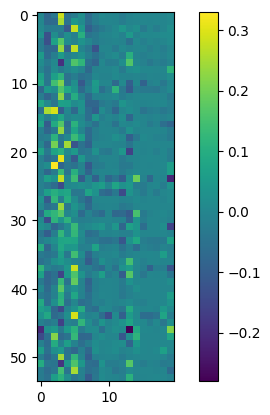

In [71]:
plt.imshow(Vtest - Vtest_temporal)
plt.colorbar()

# Impute a whole slice? I used Wasserstein barycenter, can switch to Gromov--Wasserstein

Text(0.5, 1.0, 'Distributions')

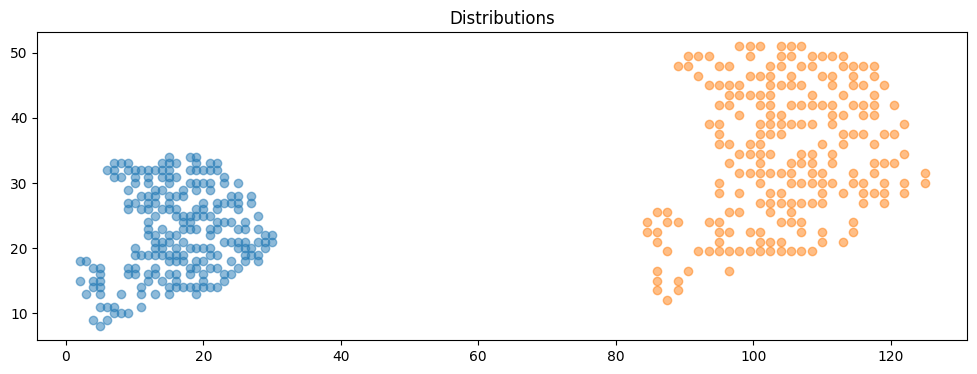

In [128]:
x1 = np.vstack( (adata_group[0].obs['x'], adata_group[0].obs['y'] ) ).T
x2 = 1.5*np.vstack( (adata_group[1].obs['x'], adata_group[1].obs['y'] ) ).T
# x2[:,0] = x2[:,0] + 80
import ot
measures_locations = [x1, x2]
measures_weights = [ot.unif(x1.shape[0]), ot.unif(x2.shape[0])]

plt.figure(1, (12, 4))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.5)
plt.scatter(x2[:, 0] + 80, x2[:, 1], alpha=0.5)
plt.title("Distributions")

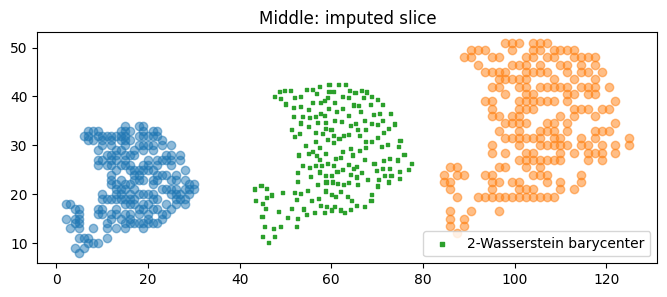

In [140]:
k = 200  # number of Diracs of the barycenter
d = 2
X_init = np.random.normal(0.0, 1.0, (k, d))  # initial Dirac locations
b = (
    np.ones((k,)) / k
)  # weights of the barycenter (it will not be optimized, only the locations are optimized)

X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, b)
plt.figure(2, (8, 3))
plt.scatter(x1[:, 0], x1[:, 1], alpha=0.5)
plt.scatter(x2[:, 0] + 80, x2[:, 1], alpha=0.5)
plt.scatter(X[:, 0] + 40, X[:, 1], s=b * 1000, marker="s", label="2-Wasserstein barycenter")
plt.title("Middle: imputed slice")
plt.legend(loc="lower right")
plt.show()

In [141]:
C.shape

(400, 214)

In [154]:
import scipy
import ot.gromov

# x1: (n1,d)   X: (k,d)   x2: (n2,d)
n1, k, n2 = adata_group[0].obs.shape[0], X.shape[0], adata_group[1].obs.shape[0]

a = np.ones(n1)/n1          # weights on x1
b = np.ones(k)/k            # weights on barycenter support (size k)
c = np.ones(n2)/n2          # weights on x2

# --- 1) Build *intra*-domain distance (structure) matrices
C1 = scipy.spatial.distance.cdist(x1, x1)   # (n1,n1)
Ck = scipy.spatial.distance.cdist(X,  X)    # (k,k)   (use if you *fix* X as barycenter support)
C2 = scipy.spatial.distance.cdist(x2, x2)   # (n2,n2)

# Option A: If X is your fixed barycenter support -> compute GW to it:
P1 = ot.gromov.gromov_wasserstein(C1, Ck, a, b)
P2 = ot.gromov.gromov_wasserstein(Ck, C2, b, c)


In [155]:
P1.sum()

np.float64(0.9999999999999998)

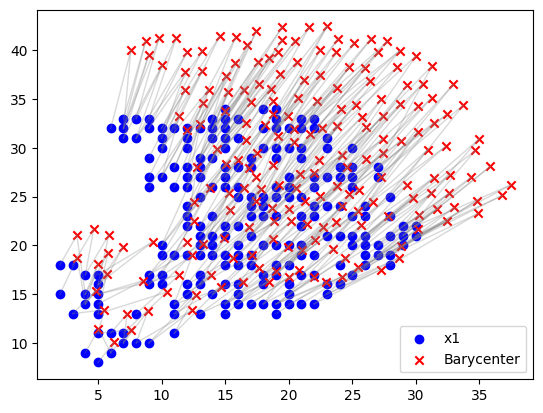

In [159]:
import numpy as np
plt.scatter(x1[:,0], x1[:,1], c='blue', label='x1')
plt.scatter(X[:,0], X[:,1], c='red', marker='x', label='Barycenter')

# draw lines for strong couplings
threshold = np.percentile(P1, 85)   # top 5% of weights
for i in range(P1.shape[0]):
    for j in range(P1.shape[1]):
        if P1[i,j] > threshold:
            plt.plot([x1[i,0], X[j,0]], [x1[i,1], X[j,1]],
                     alpha=0.3, c='gray', linewidth=1)

plt.legend()
plt.show()


In [160]:
Vtest_temporal, _ = gp_impute_spots_cross_slice(
    [], [], X,
    kernel_type="RBF",
    length_scale=3.0,
    noise_level=1e-2,
    optimize_hyperparams=False,
    clip_to_01=True,
    renormalize_rows=True,
    return_std=True,
    W_test_prev = P1.T,
    V_prev = V_all[0],
    W_test_next = P2,
    V_next = V_all[1],
    w_within = 0.0, w_prev = 0.5, w_next=0.5
)

In [161]:
x1.shape

(214, 2)

Text(0.5, 1.0, 'Imputed')

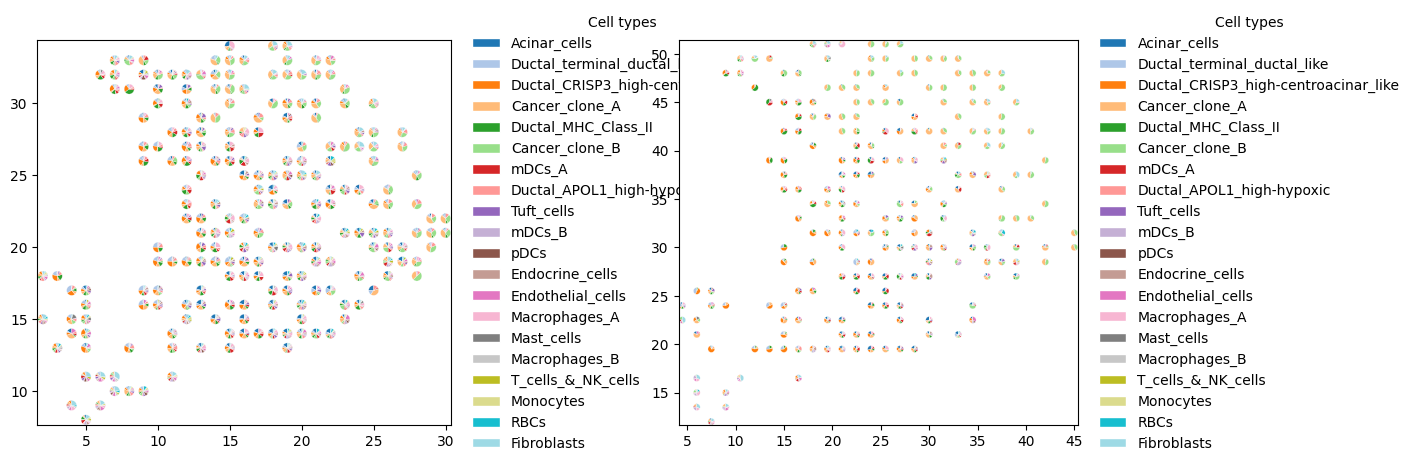

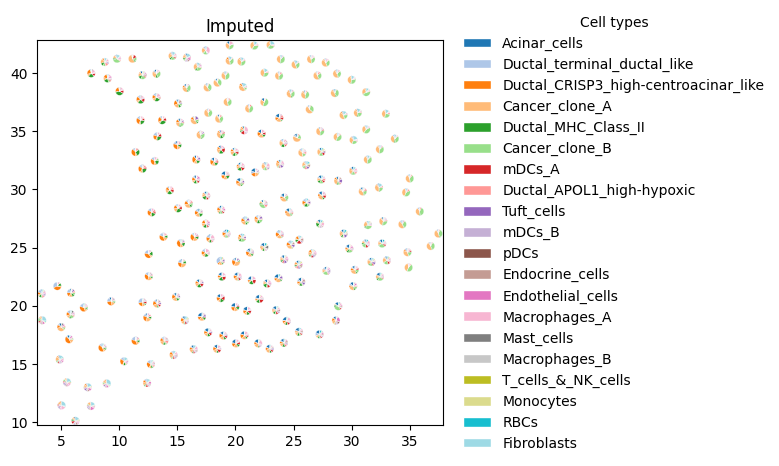

In [162]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], x1[:,0], x1[:,1], V_all[0], labels=pd_B.index.to_list(),top_n=None)
# axs[0].set_xlim([0,60])
# axs[0].set_ylim([10,70])
scatter_pies(axs[1], x2[:,0], x2[:,1], V_all[1], labels=pd_B.index.to_list(),top_n=None)
# axs[1].set_xlim([0,60])
# axs[1].set_ylim([10,70])

fig, axs = plt.subplots(1, 1, figsize=(7, 5))  # 1 row, 2 columns
scatter_pies(axs, X[:,0], X[:,1], Vtest_temporal,
             labels=pd_B.index.to_list(), top_n=None)
axs.set_title('Imputed')
# axs.set_xlim([0,60])
# axs.set_ylim([10,70])
